In [5]:
#Import modules

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from numpy import arange, log10

from functions import chunk, agg, finalize
tunique = dd.Aggregation('tunique', chunk, agg,finalize)
first = dd.Aggregation('first', chunk, agg,finalize)

## Monthly evolution

### Construct data

In [31]:
drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

colnames = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'DEPT', u'CN ID 8', u'CPA6',
       u'PYOD', u'PAYP', u'VAT', u'PRIFAC', u'DEVFAC', u'VFTE', u'VART', u'D_MASSE', u'MASSE', u'USUP', u'USUP_MT']

colname_no = dict(zip(colnames, range(18)))
# columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'VART']
columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'CN ID 8', u'VART']

df_list = []

for y in range(1997, 2014):
    df_list += [dd.read_table(drive_path+'/DP1610_MAASTRICHT1_'+str(y)+'.txt', 
            usecols = map(colname_no.get, columns),
            delimiter = ';', header = None, dtype = {9: 'object'})]

data = dd.concat(df_list)
data.columns = columns
data['IMPORT'] = data['FLUX'] % 2


In [34]:
# Dask has no easy sorting...
# value = data.sort_values(by = 'VART')
# value_cs = value['VART'].cumsum() / value['VART'].sum()
# data_99 = data.loc[(value_cs > .01).index]

monthly_summary = data.loc[data.VART > 1000].groupby(['IMPORT','YEAR', 'MONTH']).agg({'VART': 'sum', 'ID': tunique, 'CN ID 8': tunique})

# monthly_summary_99 = data_99.groupby(['IMPORT','YEAR', 'MONTH']).agg({'VART': 'sum', 'ID': tunique, 'CN ID 8': tunique}).loc[(value_cs > .01).index]

In [20]:
with ProgressBar():
    out = monthly_summary.compute()

out.to_csv('monthly_summary.csv')

[########################################] | 100% Completed | 14min 39.2s


### Load previously computed data

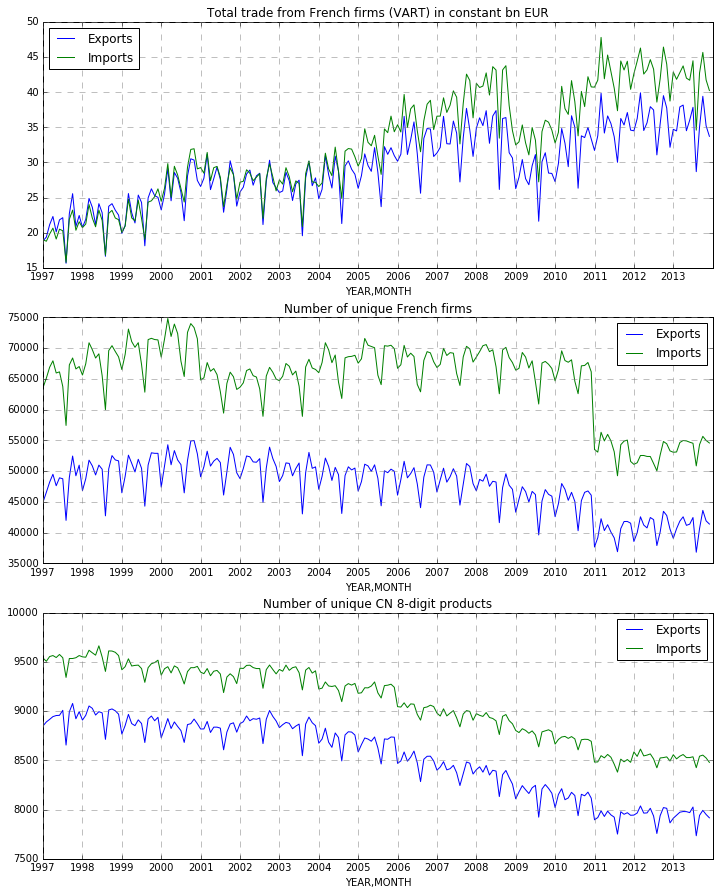

In [42]:
monthly_summary = pd.read_csv('./monthly_summary.csv')
unstacked = monthly_summary.set_index(['IMPORT', 'YEAR', 'MONTH']).unstack(0)
unstacked['VART'] = unstacked['VART']/1e9

fig, axs = plt.subplots(3, 1, figsize = (12, 15))
for i in [0, 1, 2]:
    
    ax = axs[i]
    unstacked[['VART', 'ID', 'CN ID 8'][i]].plot(ax = axs[i])

    ax.set_xticks(arange(0, 12*17+1, 12))
    ax.set_xticklabels(range(1997, 2014))
    ax.grid(linestyle='--', linewidth='0.5', color='gray')
    
    title = ['Total trade from French firms (VART) in constant bn EUR', 
             'Number of unique French firms', 
             'Number of unique CN 8-digit products'][i]
    ax.set_title(title)
    
    loc = ['upper left', 'upper right', 'upper right'][i]
    ax.legend(['Exports', 'Imports'], loc = loc)
    
plt.savefig('./Figures/mn_total_trade.png')

In [13]:
firm_sizes = pd.read_csv('firm_sizes.csv')
buyr_sizes = pd.read_csv('buyr_sizes.csv')

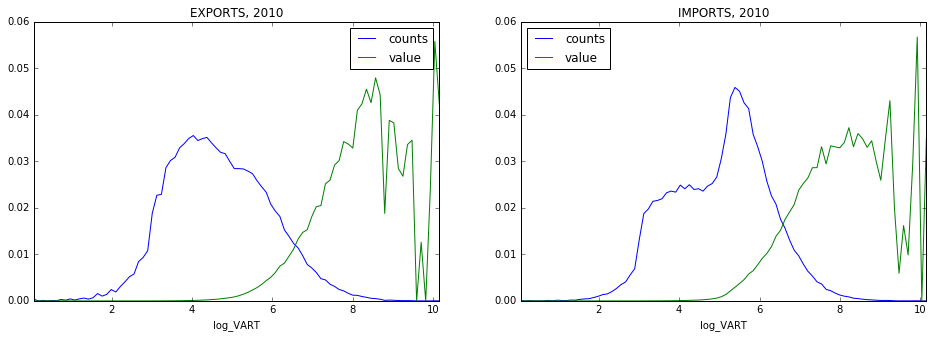

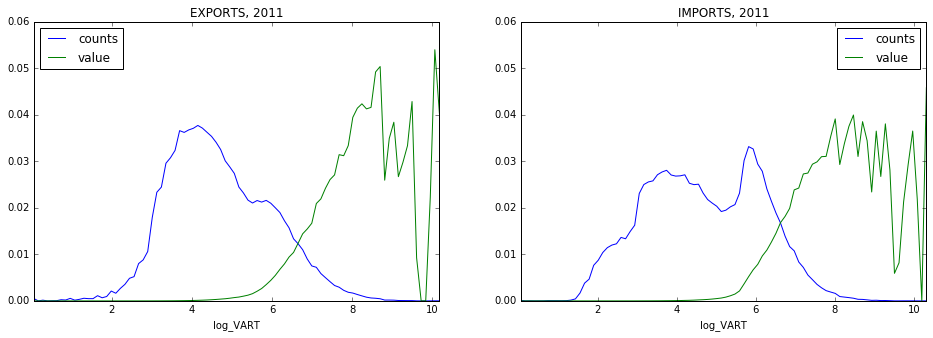

In [14]:
from numpy import inf, nan

fs_df = firm_sizes

for y in [2010, 2011]:
    fig, axs = plt.subplots(1, 2, figsize = (16, 5))
    for i in [0, 1]:
        fs_df_slice = fs_df.loc[(fs_df.YEAR == y) & (fs_df.IMPORT == i)].replace(-inf, nan).dropna()
        fs_df_slice['bin'], bins_x = pd.cut(fs_df_slice['log_VART'], 90, retbins=True)

        fs_ct_val = fs_df_slice.groupby('bin').agg({'ID': 'count', 'VART': sum}).rename(columns = {'ID': 'counts', 'VART': 'value'})

        fs_ct_val/=fs_ct_val.sum()
        ax = axs[i]
        fs_ct_val['log_VART'] = (bins_x[:-1] + bins_x[1:])/2.
        fs_ct_val.plot(x = 'log_VART', y = 'counts', ax = ax)
        fs_ct_val.plot(x = 'log_VART', y = 'value', ax = ax)
        ax.set_title('IMPORTS, '+str(y)) if i == 1 else ax.set_title('EXPORTS, '+str(y))
        ax.set_ylim(0, 0.06)

### Value by buyer, seller size

In [6]:
drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

colnames = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'DEPT', u'CN ID 8', u'CPA6',
       u'PYOD', u'PAYP', u'VAT', u'PRIFAC', u'DEVFAC', u'VFTE', u'VART', u'D_MASSE', u'MASSE', u'USUP', u'USUP_MT']

colname_no = dict(zip(colnames, range(18)))
columns = [u'YEAR', u'FLUX', u'ID', u'VAT', u'VART']

df_list = []

for y in range(1997, 2014):
    df_list += [dd.read_table(drive_path+'/DP1610_MAASTRICHT1_'+str(y)+'.txt', 
            usecols = map(colname_no.get, columns),
            delimiter = ';', header = None, dtype = {9: 'object'})]

data = dd.concat(df_list)
data.columns = columns
data['IMPORT'] = data['FLUX'] % 2

links = data.groupby(['IMPORT','YEAR','ID','VAT'])['VART'].sum().reset_index()


In [7]:
with ProgressBar():
    out = links.compute()
out.to_csv('buyer_seller_links.csv', index = False)

[########################################] | 100% Completed | 16min 41.3s


In [4]:
links = pd.read_csv('./buyer_seller_links.csv')
links = links.loc[links.VART > 1000]

links['log_VART'] = log10(links.VART)#.replace(-inf, nan).dropna()
# links['bin'], bins_x = pd.cut(links['log_VART'], 90, retbins=True)

In [19]:
firm_sizes.loc[(firm_sizes.VART > 10000000) & (firm_sizes.YEAR == 2013)]

ID  IMPORT  YEAR       VART  log_VART
648890        793       0  2013   46563862  7.668049
648891        793       1  2013   11805238  7.072075
648906       2971       1  2013   10123549  7.005333
648913       3110       1  2013   10970616  7.040231
648939       4878       0  2013   72884968  7.862638
648940       4878       1  2013   10415228  7.017669
648941       4902       0  2013   38667445  7.587345
648942       4902       1  2013   57890883  7.762610
648943       4910       0  2013   52728535  7.722046
648944       4910       1  2013   11333975  7.054382
648947       8143       0  2013  156711319  8.195100
648955       9059       0  2013   12119834  7.083497
648976      10883       0  2013   57295893  7.758123
648977      10883       1  2013   10222766  7.009568
648979      10974       1  2013   21101483  7.324313
648997      14000       1  2013   12207763  7.086636
649012      19314       0  2013   29654402  7.472089
649013      19314       1  2013   20661282  7.315157
649014      19363       0  2013   18708105  7.272030
649015      19363       1  2013   11222704  7.050098
649022      19611       0  2013   18882249  7.276054
649040      35559       1  2013   20978404  7.321772
649054      44528       1  2013   16695063  7.222588
649055      45202       0  2013   10094683  7.004093
649081      53800       1  2013   57051223  7.756265
649093      57033       1  2013   10826837  7.034502
649094      57116       1  2013   13557330  7.132174
649110      62173       1  2013   18308094  7.262643
649159      80712       1  2013   10452299  7.019212
649175      89895       1  2013   12334074  7.091107
...           ...     ...   ...        ...       ...
833295  790176317       1  2013   16270045  7.211389
833322  790462972       0  2013   24680036  7.392346
833652  793369125       1  2013   11331788  7.054298
833778  907050462       1  2013   27054421  7.432238
833833  325032878       1  2013   13146384  7.118806
833939  482582426       1  2013   13300000  7.123852
834044  538125956       1  2013   12566896  7.099228
834133  794833566       1  2013   10998185  7.041321
834222  515550028       0  2013   25345494  7.403901
834262  793369125       0  2013   15068787  7.178078
834263  793428319       0  2013   71286190  7.853005
840022  794537621       0  2013   10109704  7.004738
840108  412838526       1  2013   11394601  7.056699
840117  418768727       1  2013   22477347  7.351745
845340  528655574       1  2013   16282018  7.211708
846099  752925594       0  2013   13681722  7.136141
852885  533247979       0  2013   17333592  7.238889
853062  538760125       0  2013   14735561  7.168367
853068  538789405       1  2013   39186489  7.593136
854639  537721797       1  2013   31032723  7.491820
854665  753480433       1  2013   15306195  7.184867
854736  798295846       1  2013   13949921  7.144572
854860  537721797       0  2013   43882489  7.642291
856824  410615900       0  2013   20530843  7.312407
861237  793856139       1  2013   14964074  7.175050
861710  410615900       1  2013   16301309  7.212222
861970  440300200       0  2013   43279310  7.636280
861971  442251971       0  2013   17219351  7.236017
868129  792870743       0  2013   29691762  7.472636
868601  798885950       1  2013   10808137  7.033751

[9449 rows x 5 columns]

In [21]:
links.loc[links.ID == 4878]

IMPORT  YEAR    ID        VAT     VART  log_VART
156            0  1997  4878  AT0020982   253488  5.403957
157            0  1997  4878  BE0014884   345841  5.538876
158            0  1997  4878  BE0047377  1731395  6.238396
159            0  1997  4878  BE0093407    90879  4.958464
160            0  1997  4878  DE0003734  3035095  6.482172
161            0  1997  4878  DE0029473   162607  5.211139
162            0  1997  4878  DE0550716  8636209  6.936323
163            0  1997  4878  DE0551096   414626  5.617657
164            0  1997  4878  ES0143017    78045  4.892345
165            0  1997  4878  ES0151213     1357  3.132580
166            0  1997  4878  ES0172847     6104  3.785615
167            0  1997  4878  ES0174975    77240  4.887842
168            0  1997  4878  ES0175691    41778  4.620948
169            0  1997  4878  ES0181649  1051717  6.021899
170            0  1997  4878  ES0185329  3660448  6.563534
171            0  1997  4878  ES0195704     2515  3.400538
172            0  1997  4878  ES0196129   257457  5.410705
173            0  1997  4878  ES0196162    41201  4.614908
174            0  1997  4878  ES0209111    37291  4.571604
175            0  1997  4878  ES0219396   321500  5.507181
176            0  1997  4878  ES0466889     4513  3.654465
177            0  1997  4878  GB0061713  3160498  6.499756
178            0  1997  4878  GB0087900   925925  5.966576
179            0  1997  4878  GB0114521    19493  4.289879
180            0  1997  4878  GB0139895  2685746  6.429065
181            0  1997  4878  IT0087135     1452  3.161967
182            0  1997  4878  IT0315629   182434  5.261106
183            0  1997  4878  PT0029745    29276  4.466512
184            0  1997  4878  SE0009725  1183802  6.073279
293121         0  1997  4878  DE0018375   230857  5.363343
...          ...   ...   ...        ...      ...       ...
20032345       0  2013  4878  NL0016070    75293  4.876755
20032346       0  2013  4878  NL0130003   257470  5.410727
20032347       0  2013  4878  NL0144211    30637  4.486246
20032348       0  2013  4878  NL0177918    15508  4.190556
20032349       0  2013  4878  NL2137313  1789127  6.252641
20032350       0  2013  4878  PL0008369    79745  4.901703
20032351       0  2013  4878  PL0021646    87527  4.942142
20032352       0  2013  4878  PL0034185    23077  4.363179
20032353       0  2013  4878  PL0056080   336846  5.527431
20032354       0  2013  4878  RO0006110    40291  4.605208
20032355       0  2013  4878  SE0003916  1290209  6.110660
20032356       0  2013  4878  SE0006531  4210164  6.624299
20032357       0  2013  4878  SE0009725   186064  5.269662
20032358       0  2013  4878  SE0010265   658912  5.818827
20032359       0  2013  4878  SE0038757   200597  5.302324
20032360       0  2013  4878  SI0004416   936440  5.971480
20032361       0  2013  4878  SK0006368  2419147  6.383662
20384590       0  2013  4878  CZ0000232     3007  3.478133
20384591       0  2013  4878  CZ0007842     8002  3.903199
20540552       0  2013  4878  DE0614514     1128  3.052309
20540553       0  2013  4878  GB0139994    13321  4.124537
20657667       0  2013  4878  CZ0000449     3308  3.519566
20657668       0  2013  4878  ES0201271     6300  3.799341
20657669       0  2013  4878  HU0003663     1368  3.136086
20745576       0  2013  4878  ES0211176    21000  4.322219
20745577       0  2013  4878  SE0032184    29260  4.466274
20811603       0  2013  4878  EE0002674     7388  3.868527
20868074       0  2013  4878  DE0626876    20294  4.307368
20962254       0  2013  4878  SE0030960    17831  4.251176
21075380       0  2013  4878  SE0049177     1286  3.109241

[977 rows x 6 columns]

In [7]:
links_y = links.loc[links.YEAR == 2013]

firm_sizes = pd.read_csv('firm_sizes.csv')
buyr_sizes = pd.read_csv('buyr_sizes.csv')

firm_sizes_y = firm_sizes.loc[(firm_sizes.YEAR == 2013) & (firm_sizes.IMPORT == 0)]
buyr_sizes_y = buyr_sizes.loc[(buyr_sizes.YEAR == 2013) & (buyr_sizes.IMPORT == 0)]

In [8]:
links_val = links_y.merge(firm_sizes_y[['ID','log_VART']], on = 'ID').merge(buyr_sizes_y[['VAT', 'log_VART']], on = 'VAT')

In [9]:
from numpy import arange
bins = arange(3, 10, .1)
links_val['x_bin'] = pd.cut(links_val['log_VART_x'], bins)
links_val['y_bin'] = pd.cut(links_val['log_VART_y'], bins)

In [10]:
result = links_val.groupby(['x_bin','y_bin']).agg({'log_VART_x': 'mean', 'log_VART_y': 'mean', 
                                                   'VART': 'sum', 'YEAR': 'count'})

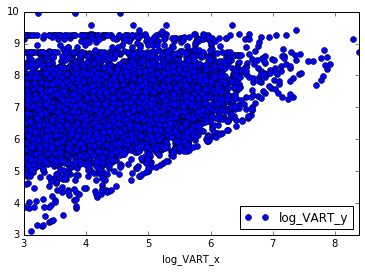

In [16]:
links_val.sample(10000).plot(x = 'log_VART_x', y = 'log_VART_y', marker = 'o', linewidth = 0)

TypeError: Cannot cast array data from dtype('float64') to dtype('S32') according to the rule 'safe'

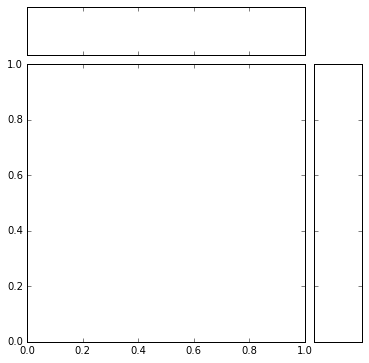

In [71]:
import seaborn as sns

g = sns.jointplot("log_VART_x", "log_VART_y", data=result, kind="kde", space=0, color="g")

# ax = sns.kdeplot(result.log_VART_x, setosa.log_VART_y,
#                  cmap="Reds", shade=True, shade_lowest=False)
# ax = sns.kdeplot(result.sepal_width, virginica.sepal_length,
#                  cmap="Blues", shade=True, shade_lowest=False)

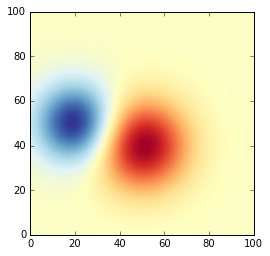

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


def normal_pdf(x, mean, var):
    return np.exp(-(x - mean)**2 / (2*var))


# Generate the space in which the blobs will live
xmin, xmax, ymin, ymax = (0, 100, 0, 100)
n_bins = 100
xx = np.linspace(xmin, xmax, n_bins)
yy = np.linspace(ymin, ymax, n_bins)

# Generate the blobs. The range of the values is roughly -.0002 to .0002
means_high = [20, 50]
means_low = [50, 60]
var = [150, 200]

gauss_x_high = normal_pdf(xx, means_high[0], var[0])
gauss_y_high = normal_pdf(yy, means_high[1], var[0])

gauss_x_low = normal_pdf(xx, means_low[0], var[1])
gauss_y_low = normal_pdf(yy, means_low[1], var[1])

weights_high = np.array(np.meshgrid(gauss_x_high, gauss_y_high)).prod(0)
weights_low = -1 * np.array(np.meshgrid(gauss_x_low, gauss_y_low)).prod(0)
weights = weights_high + weights_low

# We'll also create a grey background into which the pixels will fade
greys = np.empty(weights.shape + (3,), dtype=np.uint8)
greys.fill(70)

# First we'll plot these blobs using only ``imshow``.
vmax = np.abs(weights).max()
vmin = -vmax
cmap = plt.cm.RdYlBu

fig, ax = plt.subplots()
# ax.imshow(greys)
ax.imshow(weights, extent=(xmin, xmax, ymin, ymax), cmap=cmap)
# ax.set_axis_off()

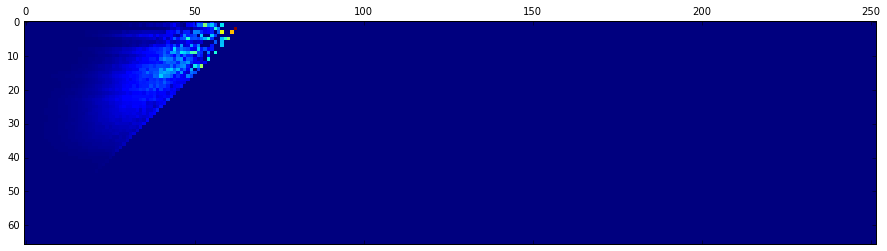

In [92]:
plt.matshow(result.unstack(0).sort_index(ascending = False).fillna(0).values)

In [78]:
result.unstack(0).sort_index(ascending = False)

VART                                               \
x_bin      (3.0, 3.1] (3.1, 3.2] (3.2, 3.3] (3.3, 3.4]  (3.4, 3.5]   
y_bin                                                                
(9.8, 9.9]        NaN        NaN        NaN        NaN         NaN   
(9.7, 9.8]     9196.0    15615.0    28033.0    25551.0     35918.0   
(9.6, 9.7]        NaN        NaN        NaN        NaN      8665.0   
(9.5, 9.6]     1161.0     5242.0     1600.0     2435.0      2800.0   
(9.4, 9.5]     2279.0        NaN     3538.0    14997.0     13609.0   
(9.3, 9.4]     4423.0     4504.0     5266.0     9195.0     13564.0   
(9.2, 9.3]   620067.0   801259.0  1081506.0  1393638.0   1615470.0   
(9.1, 9.2]    45653.0    47504.0    85163.0   149439.0    131467.0   
(9.0, 9.1]     7702.0    12250.0    17930.0    15336.0     48516.0   
(8.9, 9.0]    19304.0    21612.0    33837.0    47883.0     85232.0   
(8.8, 8.9]   160510.0   225142.0   284998.0   371771.0    455608.0   
(8.7, 8.8]   424912.0   565776.0   691091.0   952313.0   1200551.0   
(8.6, 8.7]    95436.0   114535.0   165134.0   203138.0    310437.0   
(8.5, 8.6]   198505.0   224492.0   293047.0   470001.0    596189.0   
(8.4, 8.5]   345661.0   412443.0   609981.0   787420.0    986011.0   
(8.3, 8.4]   275309.0   310524.0   451701.0   698666.0    871329.0   
(8.2, 8.3]   236451.0   353505.0   463071.0   732000.0   1048948.0   
(8.1, 8.2]   611968.0   886474.0  1039002.0  1408002.0   1770985.0   
(8.0, 8.1]   503333.0   766220.0  1022535.0  1526507.0   2209756.0   
(7.9, 8.0]  3312217.0  4107478.0  4702781.0  5482258.0   6253136.0   
(7.8, 7.9]  1437444.0  1801529.0  2259869.0  3167330.0   3941804.0   
(7.7, 7.8]  3508401.0  4400439.0  5432963.0  6617056.0   8292656.0   
(7.6, 7.7]   883898.0  1242337.0  1777209.0  2424767.0   3432741.0   
(7.5, 7.6]  1460611.0  2137117.0  2822140.0  3982289.0   5188584.0   
(7.4, 7.5]  1755252.0  2395590.0  3404941.0  4613348.0   5923754.0   
(7.3, 7.4]  2182327.0  3057676.0  3990244.0  5494858.0   7138919.0   
(7.2, 7.3]  2618467.0  3653665.0  4960671.0  6732909.0   8520882.0   
(7.1, 7.2]  2659419.0  3778628.0  4830220.0  6609441.0   8643122.0   
(7.0, 7.1]  3195674.0  4475047.0  6171052.0  8024170.0  10324209.0   
(6.9, 7.0]  3423133.0  4692932.0  6194009.0  8061917.0   9786537.0   
...               ...        ...        ...        ...         ...   
(5.9, 6.0]  3570535.0  4431601.0  5792062.0  6906305.0   8594607.0   
(5.8, 5.9]  2818304.0  3713070.0  4594194.0  5584311.0   6988787.0   
(5.7, 5.8]  2397610.0  3024932.0  3984180.0  4962552.0   5907867.0   
(5.6, 5.7]  1626675.0  2137856.0  2750108.0  3683124.0   4403004.0   
(5.5, 5.6]  1195301.0  1671230.0  1895904.0  2416664.0   2945557.0   
(5.4, 5.5]   785526.0  1045231.0  1148506.0  1501518.0   1933428.0   
(5.3, 5.4]   693572.0   910273.0  1140635.0  1485073.0   1573328.0   
(5.2, 5.3]   564672.0   725735.0   897279.0  1053468.0   1411572.0   
(5.1, 5.2]   373535.0   441017.0   695225.0   841032.0   1107830.0   
(5.0, 5.1]   450235.0   520408.0   664923.0   825439.0   1089409.0   
(4.9, 5.0]   445497.0   558113.0   682565.0   814557.0    904386.0   
(4.8, 4.9]   309641.0   411658.0   579184.0   709424.0    776251.0   
(4.7, 4.8]   216988.0   317090.0   374951.0   511284.0    602006.0   
(4.6, 4.7]   187797.0   257807.0   312349.0   409361.0    551004.0   
(4.5, 4.6]   286734.0   329767.0   501899.0   606130.0    723897.0   
(4.4, 4.5]   324767.0   428602.0   513121.0   714090.0    748884.0   
(4.3, 4.4]   205119.0   272237.0   310909.0   363956.0    414567.0   
(4.2, 4.3]   267168.0   373038.0   483201.0   553594.0    729937.0   
(4.1, 4.2]   160883.0   189604.0   209253.0   283410.0    359028.0   
(4.0, 4.1]   137648.0   218250.0   252364.0   295277.0    315921.0   
(3.9, 4.0]    87847.0    99229.0   135130.0   199912.0    263471.0   
(3.8, 3.9]   102561.0   131244.0   189898.0   193659.0    154810.0   
(3.7, 3.8]   102423.0   120017.0   202550.0   251292.0    308889.0   
(3.6, 3.7]    71575.0    94

In [ ]:
# # dd.read_csv('2014-*.csv')

# # drive_path = './../export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'
# drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

# n_bins = 20
# df_list = n_bins * [ 0 ]

# for dataset_i in range(n_bins):
#     df_list[dataset_i] = dd.read_csv(drive_path+'/samplings/YMxpb_size20'+str(dataset_i).zfill(2)+'.csv')#,
# #                                     usecols = ['YEAR','ID','VAT','VART_sum'])

# data = dd.concat(df_list)
# data = data.groupby(['YEAR','ID','VAT'])['VART_sum'].sum().reset_index()

In [ ]:
# with ProgressBar():
#     out = data.compute()
# out.to_csv('buyer_seller_links.csv', index = False)

# data = dd.from_pandas(out, npartitions = 100)

In [14]:
links = pd.read_csv('./buyer_seller_links.csv')
links = links.loc[links.VART > 1000]
links_count = links.groupby('YEAR').agg({'VART': 'count', 'ID': 'nunique', 'VAT': 'nunique'})
links_count = links_count.rename(columns = {'VART': 'pairs', 'ID': 'FR sellers', 'VAT': 'foreign buyers'})
links_pct_change = 100*links_count.pct_change().round(4).fillna('')

In [17]:
links_summary = pd.concat([links_count,links_pct_change], axis = 1)
links_summary.columns = pd.MultiIndex.from_product([['count', 'yearly pct change'], links_count.columns])
links_summary

count                           yearly pct change             \
       pairs FR sellers foreign buyers             pairs FR sellers   
YEAR                                                                  
2010  946037      42463         437200                                
2011  834748      26690         406142            -11.76     -37.15   
2012  830036      24846         404678             -0.56      -6.91   
2013  829460      24768         403480             -0.07      -0.31   

                     
     foreign buyers  
YEAR                 
2010                 
2011           -7.1  
2012          -0.36  
2013           -0.3

### Buyers and selers by foreign country

In [81]:
drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

colnames = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'DEPT', u'CN ID 8', u'CPA6',
       u'PYOD', u'PAYP', u'VAT', u'PRIFAC', u'DEVFAC', u'VFTE', u'VART', u'D_MASSE', u'MASSE', u'USUP', u'USUP_MT']

colname_no = dict(zip(colnames, range(18)))
columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'PYOD', u'VART']

df_list = []

for y in range(2010, 2014):
    df_list += [dd.read_table(drive_path+'/DP1610_MAASTRICHT1_'+str(y)+'.txt', 
            usecols = map(colname_no.get, columns),
            delimiter = ';', header = None, dtype = {9: 'object'})]

data = dd.concat(df_list)
data.columns = columns
data['IMPORT'] = data['FLUX'] % 2

data_by_dest = data.groupby(['IMPORT','YEAR','ID','PYOD'])['VART'].sum().reset_index()


In [83]:
result = data_by_dest.groupby(['PYOD', 'YEAR']).agg({'ID': tunique, 'VART': 'sum'})

In [85]:

with ProgressBar():
    out = result.compute()

[########################################] | 100% Completed |  4min 19.5s


In [92]:
out.to_csv('./destination.csv')

In [101]:
largest = [u'DZ', u'SE', u'TR', u'PL', u'JP', u'RU', u'CH', u'NL', u'GB', u'CN',
       u'US', u'ES', u'IT', u'BE', u'DE']

In [111]:
#Largest markets in volume (millions of EUR)
(out.loc[largest].unstack()['VART'].T/1e6).round().astype(int).reindex(largest, axis = 1)

PYOD     DZ     SE     TR     PL     JP     RU     CH     NL     GB     CN  \
YEAR                                                                         
2010   7562  10793  11670  12946  14909  18567  22387  35683  46281  48498   
2011  10160  11630  12644  14438  16073  21391  24814  40320  49962  54775   
2012  10266  10936  12611  14594  16689  21067  25667  41408  52168  56770   
2013  10143  10529  12299  14852  15111  18265  25749  39782  50394  55824   

PYOD     US     ES     IT     BE      DE  
YEAR                                      
2010  48867  57719  66528  65152  144194  
2011  52654  61194  71847  69740  157916  
2012  59531  60624  69670  71202  162057  
2013  59725  60025  66885  72822  157698

In [113]:
#Largest markets in sellers
(out.loc[largest].unstack()['ID'].T).round(-1).astype(int).reindex(largest, axis = 1)

PYOD    DZ     SE     TR     PL     JP    RU     CH     NL     GB     CN  \
YEAR                                                                       
2010  7200  14190  13510  16960  16230  6310  43260  36670  34720  38870   
2011  6660  11540  14370  13750  17960  6670  45560  26500  25570  47000   
2012  6880  11460  14580  14210  17740  6900  46480  25910  24940  45580   
2013  7010  11380  15450  14770  18620  7290  48960  26000  25130  51590   

PYOD     US     ES     IT     BE     DE  
YEAR                                     
2010  36060  43690  51290  52410  54630  
2011  48120  31290  36170  34940  38530  
2012  42500  30510  34650  33420  37020  
2013  48910  30570  34500  33280  36740

### Degree distribution

In [121]:
links['PERIOD'] = (links['YEAR'] - 1996) // 2

In [127]:
degrees = links.groupby(['PERIOD', 'ID'])[['VAT']].nunique().rename(columns = {'VAT': 'ID_degree'})

In [135]:
degrees['log_ID_degree'] = log10(degrees['ID_degree'])
degrees['bin_ID_degree'] = pd.cut(degrees['log_ID_degree'], arange(-.25, 4.5, 0.25))

In [137]:
degree_dist = degrees.reset_index().groupby(['PERIOD', 'bin_ID_degree'])[['ID']].count()

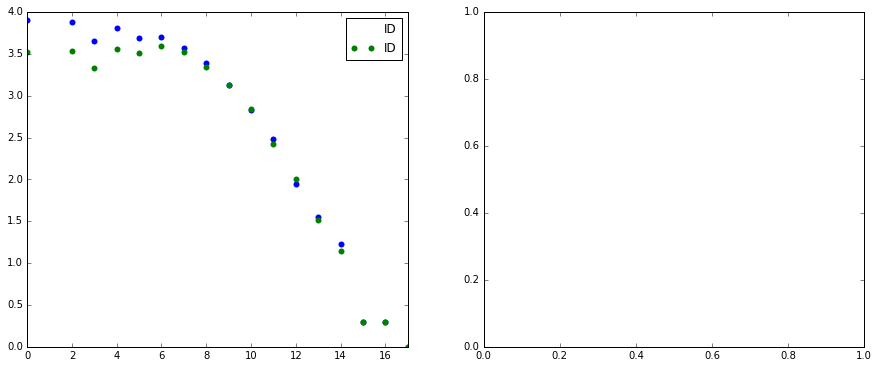

In [147]:
fig, axs = plt.subplots(1, 2, figsize =(15, 6))

ax = axs[0]
for t in [7, 8]:
    log10(degree_dist.loc[t]).reset_index().plot(marker = 'o', linewidth = 0, ax = ax, mec = 'None')

## Degree distribution and assortativity

In [ ]:
# window = 3
# assortativity_res = []
ID_degree_res = []
VAT_degree_res = []

for window in [3]:
    gap = (window-1)/2
    center_years = arange(2003, 2014, 2)
    print window

    for Yc in center_years:
        print Yc
        data_sec = data.loc[data.YEAR - Yc <= gap]
#         data_sec.groupby(['ID', 'VAT']).agg({'CN ID 8': tunique, 'VART_sum': sum })

        data_sec_by_ID = data_sec.groupby(['ID']).agg({'VAT': tunique, 'VART_sum': sum})

        ID_degree = data_sec_by_ID[['VAT']].reset_index()
        ID_degree.columns = [u'ID', u'ID_degree']
        ID_degree['center_year'] = Yc
        ID_degree['window'] = window
        
        with ProgressBar():
            ID_deg = ID_degree.compute()
            ID_deg['bin'] = pd.cut(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .25))
            ID_deg.to_csv('ID_deg_'+str(Yc)+'_'+str(window))
#         ID_degree_res += [ID_degree]     

#         ID_deg = pd.read_csv()
        sampling = ID_deg.groupby(['bin'], observed = True).apply(lambda x: x.sample(200, replace = True))

        data_sec_sample = data_sec.loc[data_sec.ID.isin(sampling['ID'].values)]
        data_sec_by_VAT = data_sec_sample.groupby(['VAT']).agg({'ID': tunique, 'VART_sum': sum})

        VAT_degree = data_sec_by_VAT[['ID']].reset_index()
        VAT_degree.columns = [u'VAT', u'VAT_degree']
        VAT_degree['center_year'] = Yc
        VAT_degree['window'] = window
        VAT_degree_res += [VAT_degree]
        with ProgressBar():
            VAT_deg = VAT_degree.compute()
            VAT_deg.to_csv('VAT_deg_'+str(Yc)+'_'+str(window))

In [ ]:
# VAT_degree_res = []
# for window in [1, 3, 5]:
#     gap = (window-1)/2
#     center_years = arange(1997, 2014, 2)
#     print window

#     for Yc in center_years:
    
#         ID_deg = pd.read_csv('./ID_deg_save.csv')
#         ID_deg = ID_deg.loc[(ID_deg.center_year == Yc) & (ID_deg.window == window)]
#         ID_deg['bin'] = pd.cut(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .25))
#         sampling = ID_deg.groupby(['bin'], observed = True).apply(lambda x: x.sample(50, replace = True))

#         data_sec_sample = data_sec.loc[data_sec.ID.isin(sampling['ID'].values)]
#         data_sec_by_VAT = data_sec_sample.groupby(['VAT']).agg({'ID': tunique, 'VART_sum': sum})

#         VAT_degree = data_sec_by_VAT[['ID']].reset_index()
#         VAT_degree.columns = [u'VAT', u'VAT_degree']
#         VAT_degree['center_year'] = Yc
#         VAT_degree['window'] = window
#         VAT_degree_res += [VAT_degree]
#         with ProgressBar():
#             VAT_deg = VAT_degree.compute()
#             VAT_deg.to_csv('VAT_deg_save_'+str(Yc)+'_'+str(window))

# #         assortativity_info = data_sec_sample.groupby(['ID', 'VAT'])[['VART_sum']].mean().reset_index().merge(
# #             ID_degree).merge(VAT_degree)
# #         assortativity_res += [assortativity_info]


In [ ]:
# ID_degree['bin'] = 
# pd.cut(log10(ID_degree['ID_degree']), bins = arange(-.49, 5.99, .5))

In [ ]:
# # ID_deg_res = dd.concat(ID_degree_res)
# # with ProgressBar():
# #     ID_deg = ID_deg_res.compute()

# VAT_deg_res = dd.concat(VAT_degree_res)
# with ProgressBar():
#     VAT_deg = VAT_deg_res.compute()

In [ ]:
# ID_deg.to_csv('./ID_deg_save.csv', index = False)
# VAT_deg.to_csv('./VAT_deg_save.csv', index = False)

In [ ]:
# plt.hist(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .25))
# plt.show()

In [ ]:
# # 
# # data_sec_sample.merge(ID_deg).merge(VAT_deg).compute()
# assortativity_info = data_sec_sample.groupby(['ID', 'VAT'])[['VART_sum']].mean().reset_index().merge(
#         ID_degree).merge(VAT_degree)

In [ ]:

# with ProgressBar():
#     assortativity_df = assortativity_info.compute()

In [ ]:
# assortativity_info.groupby(pd.cut(log10(assortativity_info['ID_degree']), bins = arange(-.49, 5.99, .5)))#['VAT_degree'].describe()

In [ ]:
# ID_deg['bin'] = pd.cut(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .5))
# ID_deg.groupby(['center_year','bin'])

In [ ]:
# data_sec_sample

In [ ]:
# # ID_deg.to_csv('degree_values.csv', index = False)

# from numpy import power
# left = power(10, arange(-.1, 5, .2)).round(1)
# right = power(10, arange(-.1, 5, .2) + .2).round(1)
# bins = pd.IntervalIndex.from_arrays(left, right)

# ID_deg_part = ID_deg.loc[(ID_deg.center_year == Yc) & (ID_deg.window == window)]
# ID_deg_part.groupby(pd.cut(ID_deg_part['ID_degree'], bins), observed = True).count().sort_index()

# sample_IDs = ID_deg_part.groupby(pd.cut(ID_deg_part['ID_degree'], bins), observed = True).apply(lambda x: x.sample(1000, replace = True))['ID'].values

# data_sec = data.loc[(data.YEAR - Yc <= gap) & (data.ID.isin(sample_IDs))]

    
# #.apply(lambda x: x.sample(5000, replace = True))['ID'].values

In [ ]:
# window = 3
# results = []
    
# gap = (3-1)/2
# center_years = arange(1997, 2014, 2)
# ID_degree_res = []
# VAT_degree_res = []



# for Yc in center_years:
#     VAT_deg_part = VAT_deg.loc[(VAT_deg.center_year == Yc) & (VAT_deg.window == window)]
#     ID_deg_part = ID_deg.loc[(ID_deg.center_year == Yc) & (ID_deg.window == window)]
#     sample_IDs = ID_deg_part.groupby(pd.cut(ID_deg_part['ID_degree'], bins), observed = True).apply(lambda x: x.sample(1000, replace = True))['ID'].values
    
#     data_sec = data.loc[(data.YEAR - Yc <= gap) & (data.ID.isin(sample_IDs))]

#     df_degrees = data_sec.merge(ID_deg_part, on = 'ID').merge(VAT_deg_part, on = ['VAT', 'center_year', 'window'])

#     results += [df_degrees]


In [ ]:
# summary_results = []

# for df_degrees in results:

#     with ProgressBar():
#         x = df_degrees.compute()

#     summary_result = x.groupby(pd.cut(x['ID_degree'], bins)).agg({'VART_sum': 'sum', 'ID_degree': 'mean',
#                                             'VAT_degree': 'describe', 'center_year' : 'median', 'window': 'median'})
#     summary_results += [summary_result]

In [ ]:
# pd.concat(summary_results).dropna().to_csv('./assortativity_2000_full.csv')

In [ ]:
# pd.concat(summary_results)

In [ ]:
# pd.concat(summary_results).dropna().to_csv('./assortativity_2000_8plus.csv')

In [ ]:
# window = 3
# results = []
    
# gap = (3-1)/2
# center_years = arange(1997, 2014, 2)
# ID_degree_res = []
# VAT_degree_res = []

# for Yc in center_years:
#     data_sec = data.loc[data.YEAR - Yc <= gap]

# #     data_sec.groupby(['ID', 'VAT']).agg({'CN ID 8': tunique, 'VART_sum': sum })

#     data_sec_by_VAT = data_sec.groupby(['VAT']).agg({'ID': tunique, 'VART_sum': sum})
#     data_sec_by_ID = data_sec.groupby(['ID']).agg({'VAT': tunique, 'VART_sum': sum})

#     VAT_degree = data_sec_by_VAT[['ID']].reset_index()
#     VAT_degree.columns = [u'VAT', u'VAT_degree']
#     ID_degree = data_sec_by_ID[['VAT']].reset_index()
#     ID_degree.columns = [u'ID', u'ID_degree']

#     df_degrees = data_sec.merge(ID_degree, on = 'ID').merge(VAT_degree, on = 'VAT')

#     from numpy import power
#     left = power(10, arange(0, 4.5, .1)).round()
#     right = power(10, arange(0, 4.5, .1) + .1).round()
#     bins = pd.IntervalIndex.from_arrays(left, right)

#     df_degrees['ID_degree_bin'] = df_degrees['ID_degree'].map_partitions(pd.cut, bins)
#     df_degrees['VAT_degree_bin'] = df_degrees['VAT_degree'].map_partitions(pd.cut, bins)
    
#     result = df_degrees.groupby('ID_degree_bin')[['ID_degree','VAT_degree']].agg({'ID_degree': 'mean', 'VAT_degree': 'mean'})
#     result.columns = pd.MultiIndex.from_product([result.columns, [str(Yc)], [str(window)]])
#     results += [result]

In [ ]:
# res = dd.concat(results, axis = 1)


# with ProgressBar():
#     out_2 = res.compute()

In [ ]:
# fig, ax = plt.subplots(1)
# df_degrees.groupby('VAT_degree_bin')['ID_degree','VAT_degree'].quantile(.25).plot(x = 'VAT_degree', y = 'ID_degree', marker = '', ax = ax)
# df_degrees.groupby('VAT_degree_bin')['ID_degree','VAT_degree'].quantile(.5).plot(x = 'VAT_degree', y = 'ID_degree', marker = '', ax = ax)
# df_degrees.groupby('VAT_degree_bin')['ID_degree','VAT_degree'].quantile(.75).plot(x = 'VAT_degree', y = 'ID_degree', marker = '', ax = ax)

# # df_degrees.groupby('ID_nunique_bin')['VAT_nunique','ID_nunique'].mean().plot(x = 'ID_nunique', y = 'VAT_nunique', marker = 'o', ax = ax)
# df_degrees.groupby('ID_nunique')['VAT_nunique'].median().plot(x = 'index', y = 'VAT_nunique', marker = '.', linewidth = 0, ax = ax)
# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
# ### Choose a bin_size, 
# size_df_list = n_size_bins * [ None ]

# for s in range(14, n_size_bins):

#     bs_ix_df = exp_index.loc[exp_index.size_bins == s]

#     size_i_df_list = []
#     for dataset_i in bs_ix_df.exp_mma_cat.unique():
#         df = df_list[dataset_i]
#         size_i_df_list += [df.loc[df.ID.isin(bs_ix_df.ID)]]

#         size_df_list[s] = pd.concat(size_i_df_list)